# Feature preparation for climate variables

Gabriel Munoz  
September 27, 2024

## Load libraries

In [ ]:
library(raster)


Loading required package: sp

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Loading required package: lattice

Loading required package: viridisLite

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ tidyr::extract() masks raster::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ dplyr::select()  masks raster::select()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Make a function to compute the temporal slope between the change of temperature between time bins

In [ ]:
#' Calculate the temporal slope or residual variance for each grid cell in a raster stack
#'
#' This function computes either the temporal slope or the variance of the residuals 
#' from a linear regression for each grid cell in a given raster stack. The slope 
#' describes the trend over time for each cell, while the residual variance gives 
#' an indication of the variability around the trend.
#'
#' @param raster_stack A raster stack or brick where each layer represents a time point.
#' @param which A character string indicating whether to return the 'slope' (default) 
#' or the 'var' (residual variance) for each grid cell. The 'slope' indicates the rate 
#' of change over time, and 'var' reflects the variability of the model residuals.
#'
#' @return A raster object containing the computed slope or residual variance for each 
#' grid cell.
#'
#' @details The function extracts the raster values as a matrix, where each row corresponds 
#' to a spatial grid cell and each column to a time point. A linear regression is then 
#' fitted to the values for each cell, and either the slope or the variance of the 
#' residuals from this model is returned, depending on the argument provided.
#'
#' @note If all values for a grid cell are `NA`, the result for that cell will also be `NA`.
#'
#' @importFrom raster nlayers as.matrix values
#' @importFrom stats lm coef residuals sd
#'
#' @examples
#' # Example usage:
#' library(raster)
#' # Create a raster stack with random values (for demonstration)
#' r1 <- raster(matrix(runif(100), 10, 10))
#' r2 <- raster(matrix(runif(100), 10, 10))
#' r3 <- raster(matrix(runif(100), 10, 10))
#' raster_stack <- stack(r1, r2, r3)
#' 
#' # Calculate the temporal slope for each grid cell
#' slope_raster <- get_temporal_slope(raster_stack, which = 'slope')
#'
#' # Calculate the residual variance for each grid cell
#' variance_raster <- get_temporal_slope(raster_stack, which = 'var')
#'
#' @export
#' 
get_temporal_slope <- function(raster_stack, which = c('slope', 'var')){
  

  
  # Get the number of layers and create a time variable
  num_layers <- nlayers(raster_stack)
  time_points <- rev(1:num_layers)

  # Extract raster values as a matrix (each column represents a time point)
  values_matrix <- as.matrix(raster_stack)
  
  # Function to calculate the slope of the regression line for each grid cell
  calc_slope <- function(values, time_points, which = c('slope', 'var')) {
    if (all(is.na(values))) {
      return(NA)
    } else {
      lm_model <- lm(values ~ time_points)
      
      
      if (which == 'var') {
        return(sd(residuals(lm_model)))  # Variance of the model residuals
      } else {
        return(coef(lm_model)[2])  # Slope of the regression line
      }
    }
  }
  
  # Apply the function to each grid cell
  slope_values <- apply(values_matrix, 1, calc_slope, time_points, which)
  
  # Create a raster for the slope values
  slope_raster <- raster_stack[[1]]
  values(slope_raster) <- slope_values
  
  return(slope_raster)
  
}


## Making climate features from temperature spatiotemporal data

In [ ]:
Temp_binned  <- readRDS( 'DATA/temperature_grid/Temp_binned.rds')

## set the adequate projection

# Lambert Azimuthal Equal-Area for Europe
# Define the Lambert Azimuthal Equal-Area projection centered between NA and Europe
crs_equal_area <- CRS("+proj=laea +lat_0=45 +lon_0=-30 +datum=WGS84 +units=m")

Temp_binned <-
  Temp_binned |>
  map(function(x) {

    crs(x) <- CRS("+proj=longlat +datum=WGS84 +no_defs")

    raster::projectRaster(x, crs = crs_equal_area)

  })


## Mean temperature

In [ ]:
mean_temp <- sapply(Temp_binned, function(stack) {
  mean(stack, na.rm = TRUE)
})


In [ ]:
saveRDS(mean_temp, 'DATA/temperature_grid/mean_temp.rds')

mean_temp <- readRDS('DATA/temperature_grid/mean_temp.rds')


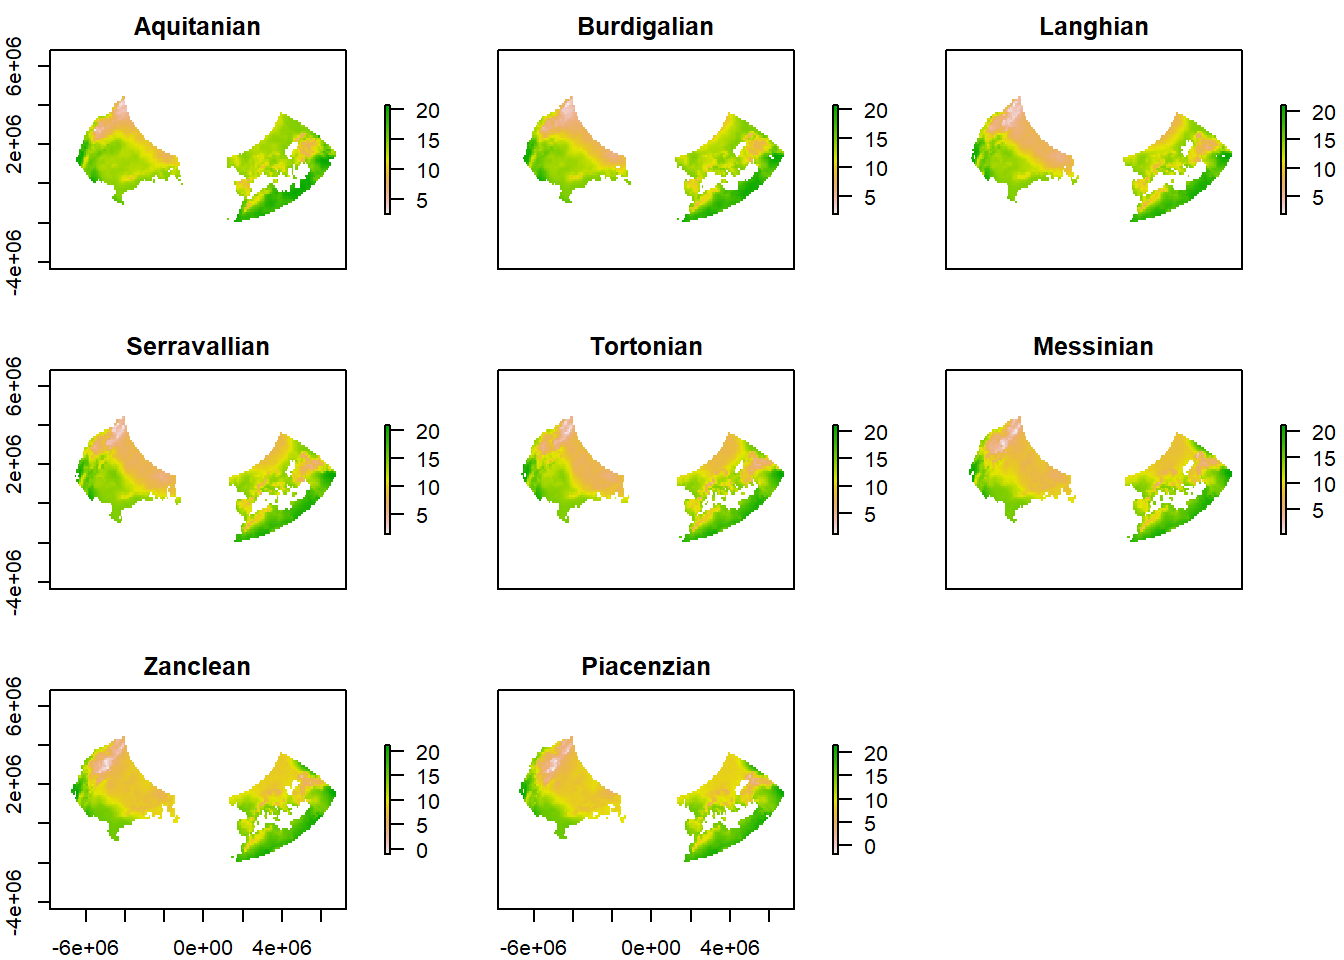

In [ ]:
mean_temp_stack <- stack(mean_temp)
plot(mean_temp_stack)


## Temperature gradient

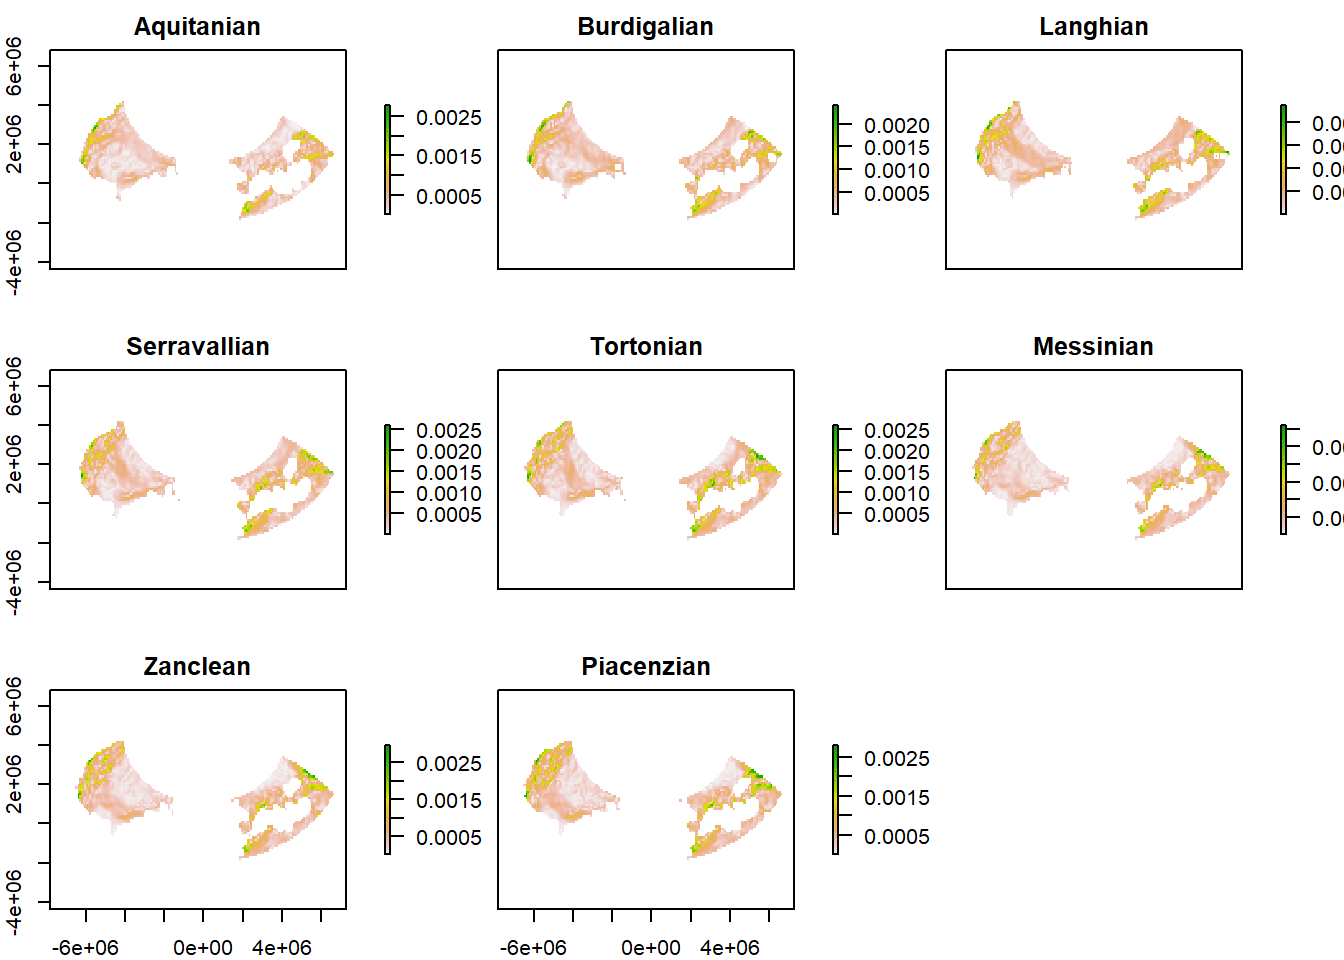

In [ ]:
temp_gradients <- lapply(mean_temp, function(stack) {
  terrain(stack, opt = "slope", 
          unit = "degrees", neighbors = 8)
})

temp_gradients <- stack(temp_gradients)

plot(temp_gradients)


## Temporal slope

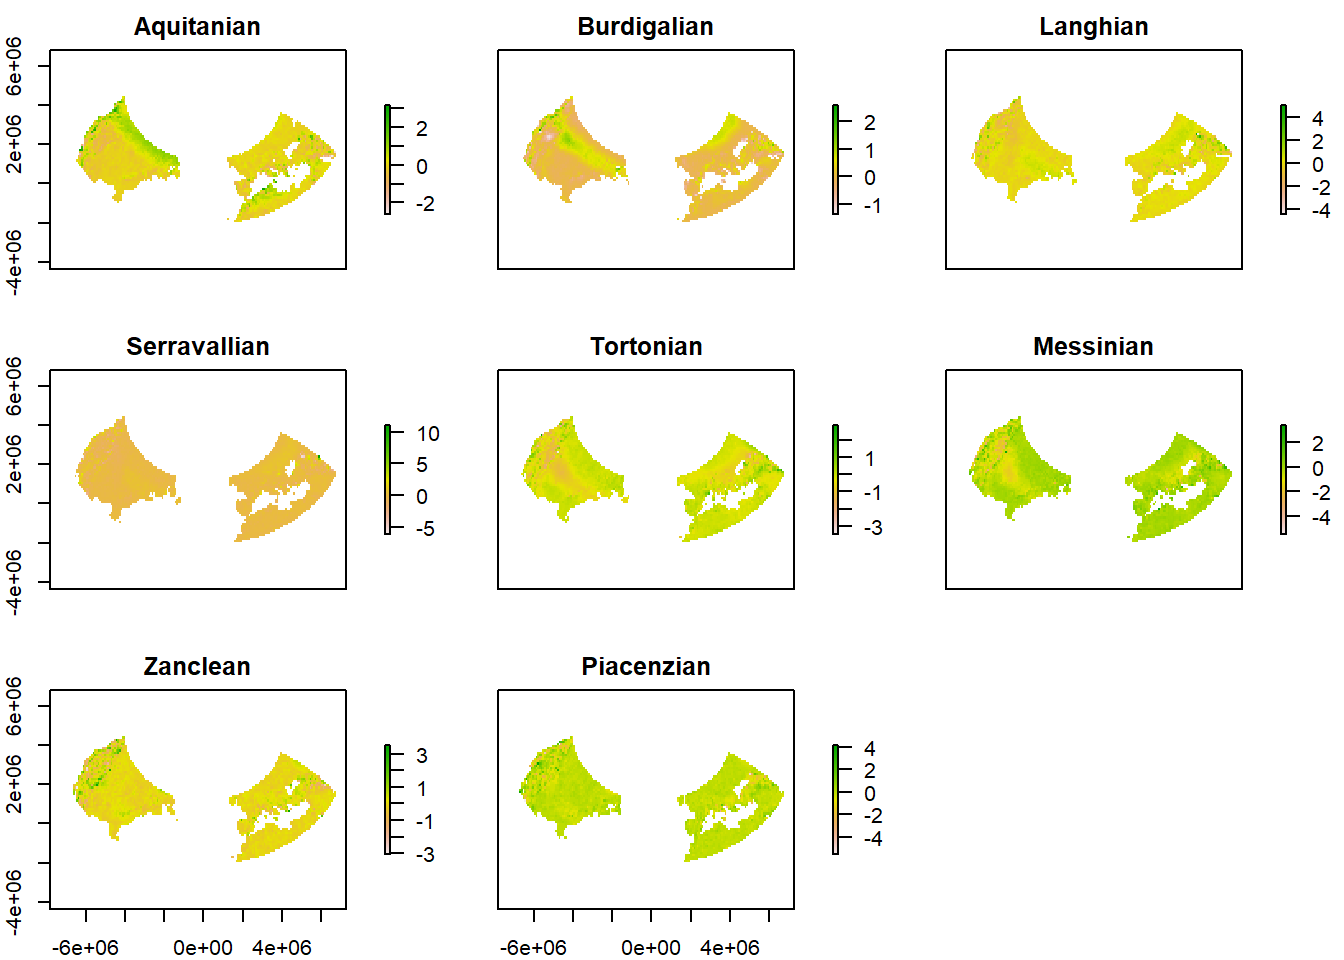

In [ ]:
temporal_slope <- Temp_binned |> map(function(x) {
  get_temporal_slope(x, which = 'slope')})

temporal_slope <- stack(temporal_slope)

plot(temporal_slope)


## Temporal variance

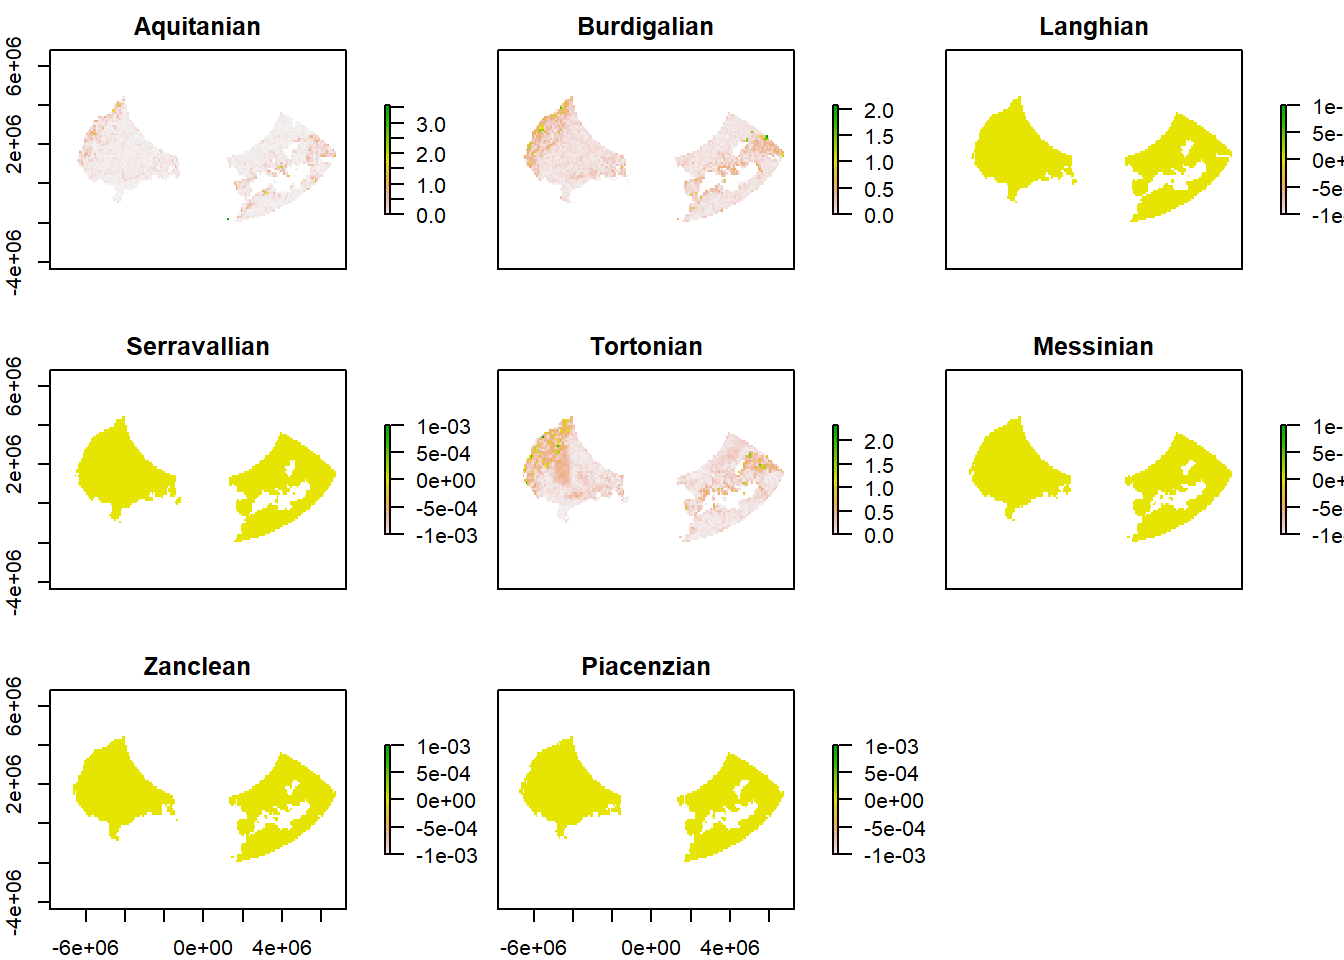

In [ ]:
temporal_variance <- Temp_binned |> map(function(x) 
  get_temporal_slope(x, which = 'var'))

temporal_variance <- stack(temporal_variance)

plot(temporal_variance)
